In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

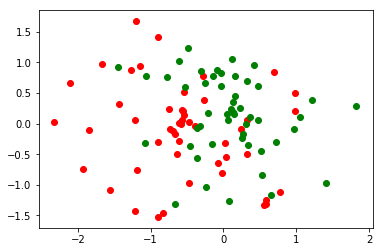

In [3]:
random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x,y = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append((x+s*math.cos(theta), y+s*math.sin(theta)))
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,(x,y),r))
    return clusters

n = 50
X = rand_clusters(2,50,1.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n, [0]*n + [1]*n]))
# label = np.array([1]*n + [0]*n)
# print (data, label)

plt.scatter(data[:n,0], data[:n,1], color=['red'])
plt.scatter(data[n:,0], data[n:,1], color=['green'])
plt.show()


In [104]:
tf.reset_default_graph()

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.get_variable(name=name, initializer=initial)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 2])
y_ = tf.placeholder(tf.float32, [None, 2])

#hidden layer
# W_fc1 = weight_variable([2, 4], 'W1')
# b_fc1 = bias_variable([4], 'b1')
# h_fc1 = tf.sigmoid(tf.matmul(x, W_fc1) + b_fc1)
# #output layer
# W_fc2 = weight_variable([4, 2], 'W2')
# b_fc2 = bias_variable([2], 'b2')
# y = tf.sigmoid(tf.matmul(h_fc1, W_fc2) + b_fc2)

n_input = 2
n_hidden = 4
n_hidden2 = 5
n_output = 2
# lmd = 1e-2
lmd = 0
# parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                            # tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output])],0))
# parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]),
#                                     tf.truncated_normal([n_hidden * n_output])
#                                    ], 0))
parameters = tf.Variable(tf.concat([tf.zeros([n_input * n_hidden]), tf.zeros([n_hidden]),\
                                    tf.zeros([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.relu(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.relu(tf.matmul(hidden, weights2) + biases2)


weights = tf.concat([tf.reshape(weights1, [-1]), tf.reshape(weights2, [-1])], 0)
regularizer = tf.nn.l2_loss(weights)

los = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)
loss = los + lmd * regularizer


grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
train_step = optimizer.apply_gradients(grads_and_vars)


In [98]:

def get_accuracy():
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return sess.run(accuracy, feed_dict={x: data, y_: label})

def get_norm_grad():
    nng = 0.
    for gv in grad:
        # print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)

def display(w):

    idx_from = 0 
    weights1 = np.reshape(w[idx_from: n_input*n_hidden], [n_input, n_hidden])
    idx_from = idx_from + n_input*n_hidden
    biases1 = np.reshape(w[idx_from: idx_from+n_hidden], [n_hidden])
    idx_from = idx_from + n_hidden
    weights2 = np.reshape(w[idx_from: idx_from+n_hidden*n_output], [n_hidden, n_output])
    idx_from = idx_from + n_hidden*n_output
    biases2 = np.reshape(w[idx_from: idx_from+n_output], [n_output])
    print (weights1)
    print (biases1)
    print (weights2)
    print (biases2)
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [20]:
sess = tf.InteractiveSession()

dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    flag = 0
    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label, lr:1e-1})
        nng = get_norm_grad()
        if nng < 1e-4:
            flag = 1
            break

    if flag != 3:
#         if i % 40 == 0:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))
#         display(w)
#         displayH(H)
        dic[int(v * 1e5)] = dic.get(int(v * 1e5), []) + [(min(eigs), w)]
sess.close() 

Epoch 1000, accuracy 75.00%, loss 0.328895, nng 0.0001646, nnw 31.2, high_eig 0.09032, low_eig 1.122e-05.


In [105]:
sess = tf.InteractiveSession()

dic = {}

for _ in range(1):

    tf.global_variables_initializer().run()
    flag = 0
    for i in range(2000):
        l = 10**(-(i+1)//1000)
        sess.run(train_step, feed_dict={x: data, y_: label, lr: l})
        nng = get_norm_grad()
#         if nng < 4e-4:
#             flag = 1
#             break    
            
        if i % 50 == 0:
            v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
            eigs = sorted(np.linalg.eigvals(H)[0])
            print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                        .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))
            display(w)
#             displayH(H)
            dic[int(v * 1e5)] = dic.get(int(v * 1e5), []) + [(min(eigs), w)]
#             py = sess.run([y], feed_dict={x: data, y_: label})    
#             print (py)
#             break

sess.close() 

Epoch 1, accuracy 50.00%, loss 1.000000, nng 0, nnw 0, high_eig 0, low_eig 0.
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[ 0.  0.]
Epoch 51, accuracy 50.00%, loss 1.000000, nng 0, nnw 0, high_eig 0, low_eig 0.
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[ 0.  0.]
Epoch 101, accuracy 50.00%, loss 1.000000, nng 0, nnw 0, high_eig 0, low_eig 0.
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[ 0.  0.]
Epoch 151, accuracy 50.00%, loss 1.000000, nng 0, nnw 0, high_eig 0, low_eig 0.
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[ 0.  0.]
Epoch 201, accuracy 50.00%, loss 1.000000, nng 0, nnw 0, high_eig 0, low_eig 0.
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[ 0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[ 0.  0.]
Epoch 251, accuracy 50.00%, loss 1.000000, 